# Computing the Screened Triple-alpha rate

We want to evaluate the 3-$\alpha$ rate with screening to understand how temperature sensitive it is.
We'll do this 2 different ways (but both will get the same answer).

In [1]:
import pynucastro as pyna

We'll define the thermodynamics first -- a composition of just He and C

In [2]:
temp = 1.e8
dens = 1.e6

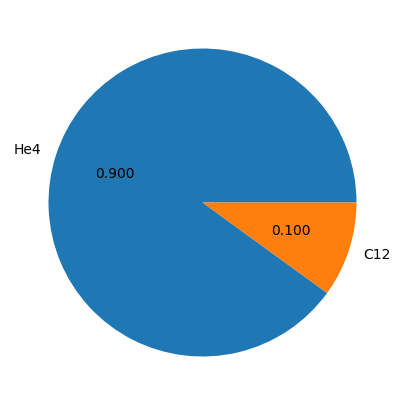

In [3]:
he4 = pyna.Nucleus("he4")
c12 = pyna.Nucleus("c12")

nuclei = [he4, c12]
comp = pyna.Composition(nuclei)
comp.X[he4] = 0.9
comp.X[c12] = 0.1

fig = comp.plot()

## Manual method

Here well read in this rate and compute the screening factors ourselves and then build up the full form of the rate

In [4]:
rl = pyna.ReacLibLibrary()

In [5]:
triple_alpha = rl.get_rate_by_name("a(aa,)c12")

Here's the temperature sensitivity of just the 3-$\alpha$ rate

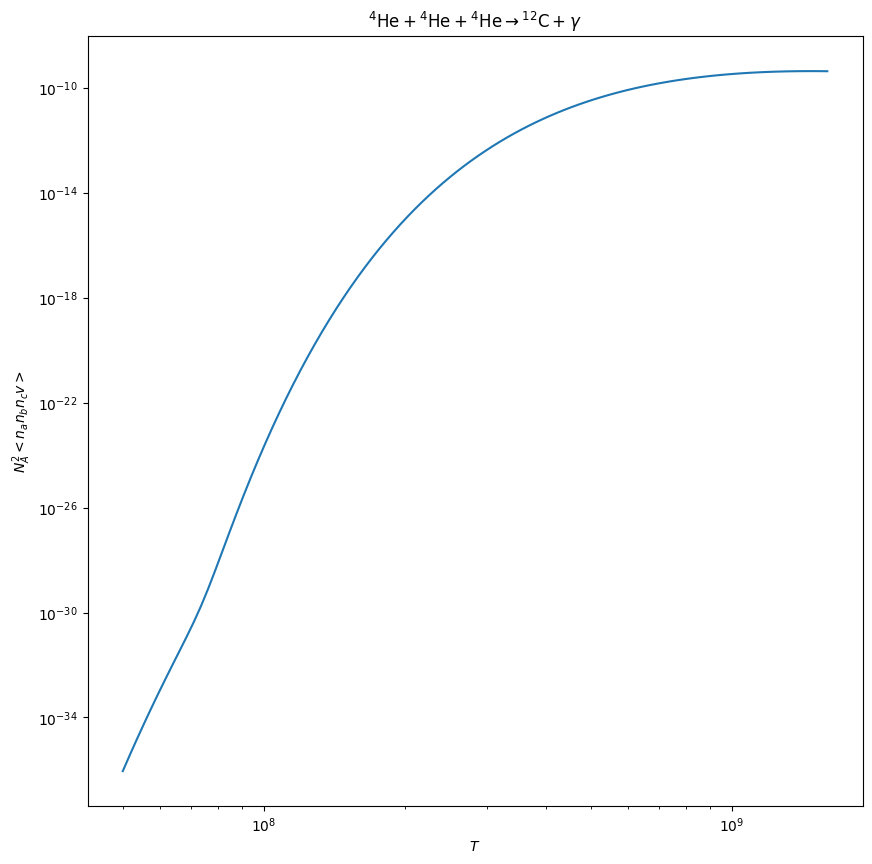

In [6]:
fig = triple_alpha.plot(Tmin=5.e7)

To compute the screening, we first need to get the plasma state

In [7]:
plasma = pyna.make_plasma_state(temp, dens, comp.get_molar())

Now, the 3-$\alpha$ rate requires 2 separate screening terms, first $\alpha + \alpha$ and then
$\alpha + {}^8\mathrm{Be}$

In [8]:
scn_fac1 = pyna.make_screen_factors(he4, he4)
scn1 = pyna.screening.screen5(plasma, scn_fac1)

scn_fac2 = pyna.make_screen_factors(he4, pyna.Nucleus("be8"))
scn2 = pyna.screening.screen5(plasma, scn_fac2)

scn = scn1 * scn2
scn

5.802207275136419

This shows that our our thermodynamic conditions, screening speeds up the rate by almost $6\times$.

Now, the total rate is:

$$r = f \rho^2 [Y({}^4\mathrm{He}]^3 \frac{N_A^2 \langle \sigma v \rangle}{3!}$$

where $f$ is the screening factor and the $3!$ is because there are 3 identical particles appearing in the reation.

We get $N_A^2 \langle \sigma v \rangle$ by evaluating the temperature sensitivity of the rate from ReacLib.

In [9]:
r = scn * dens**2 / 6.0 * comp.get_molar()[he4]**3 * triple_alpha.eval(temp)
r

2.2474377346308396e-14

This is the rate in units of $\mathrm{cm}^{-3}~\mathrm{s}^{-1}$

## Computing it via a RateCollection

We can build a simple `RateCollection` containing only this rate

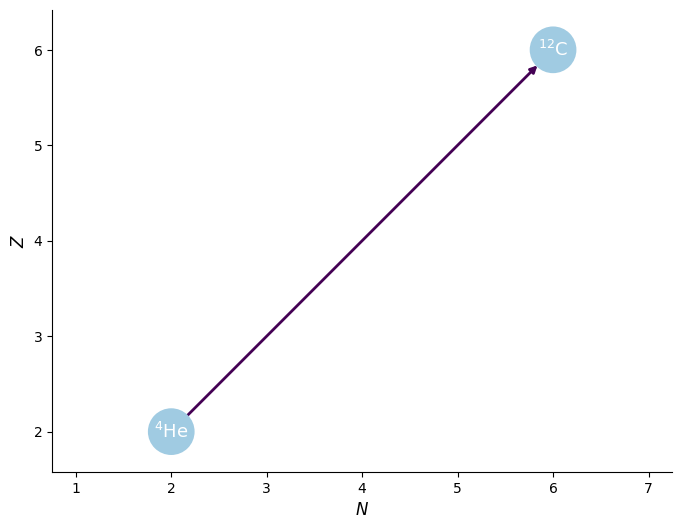

In [10]:
rc = pyna.RateCollection(rates=[triple_alpha])
fig = rc.plot()

The `evaluate_rates()` method will take the thermodynamic state and screening function (optionally) and compute the value of each of the rates in the network.

In [11]:
rc.evaluate_rates(dens, temp, comp, screen_func=pyna.screening.screen5)

{He4 + He4 + He4 ⟶ C12 + 𝛾: 2.2474377346308393e-14}

We see that we get the same value as computing it manually.